# Rooftop Solar Classification 

In this notebook, we go over how to use the open computer vision model solar_model using Google Maps Platform images to detect roof top solar panels. We will load the pretrained model in Keras, and use a function to obtain google MAP Satellite images and generate predictions.

### Introduction

The solar model uses a CNN-based deep learning model called inception_v3 pretrained on the Imagenet dataset. It finetunes this pretrained model on about 50,000 solar panel images over 42 epochs. The images were obtained from the Google Static Maps API, with dimensions of 300x300 pixels and a zoom level of 21. The final model achieves a test accuracy of 0.97, a precision of 0.91, and a recall of 0.93 [(see Evaluation)](#Evaluation). For more information about the datasets and training see **solar_model_notebook.ipynb**. Here are the links to download training, validation and tests images:  

training set: https://www.dropbox.com/scl/fo/juznkgnrqto9dw9p52tju/AP5d9S3gHSnfWE2MmfqdyPc?rlkey=7hsxr6a2sfccht27flr4ndt0x&e=2&dl=0

validation set: https://www.dropbox.com/sh/lgf0j8s3hbdi5i0/AAC3jEhaoBRm8zboUDRF6lFla?dl=0

test set: https://www.dropbox.com/sh/3yilkr8dpbbbfui/AABrLOrvMXxjvmDRdIXDMN2ha?dl=0



To start running this notebook, first install the required libraries using "pip install -r requirements.text" command. Then import the following modules:

In [7]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from get_config import get_config

### load pretrained model

Download the pretrained model and save it in a dirctory called $pretrained$ (it is a big file, 902 MB), then load the model in keras.

In [ ]:
!mkdir pretrained && curl -L -o pretrained/final_model.h5 https://www.dropbox.com/s/mprqnfq3prmqun4/final_model.h5?dl=0 

In [24]:
# Load the pretrained model
model = load_model('pretrained/final_model.h5');

2024-07-03 14:44:06.904604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 14:44:07.089658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 14:44:07.089899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Evaluation

To run the following cells, you need to download the validation and test datasets given above and place them inside the data directory. 

In [8]:
#Create data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

#Validation generator
validation_generator = datagen.flow_from_directory(
        'data/val',
        target_size=(300, 300),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

#Test generator
test_generator = datagen.flow_from_directory(
        'data/test',
        target_size=(300, 300),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

Found 2470 images belonging to 2 classes.
Found 826 images belonging to 2 classes.


In [11]:
#Generate predictions from validation set
validation_generator.reset()
val_predictions=model.predict(validation_generator,steps=2470//20+1,verbose=1)
val_predictions_classes=val_predictions>0.5
val_predictions_classes=val_predictions_classes.flatten().astype(int)
val_actual=validation_generator.classes

#Validation accuracy
print("val accuracy", metrics.accuracy_score(val_actual,val_predictions_classes).round(3))
#Precision
print("val precision", metrics.precision_score(val_actual,val_predictions_classes).round(3))
#Recall
print("val recall",metrics.recall_score(val_actual,val_predictions_classes).round(3))
#Confusion matrix
print("val confusion mx", metrics.confusion_matrix(val_actual,val_predictions_classes))


124/124 [==============================] - 12s 99ms/step
val accuracy 0.979
val precision 0.941
val recall 0.926
val confusion mx [[2054   23]
 [  29  364]]


In [12]:
#Generate predictions from test set
test_generator.reset()
test_predictions=model.predict(test_generator,steps=826//20+1,verbose=1)
test_predictions_classes=test_predictions>0.5
test_predictions_classes=test_predictions_classes.flatten().astype(int)
test_actual=test_generator.classes

#Validation accuracy
print("test accuracy", metrics.accuracy_score(test_actual,test_predictions_classes).round(3))
#Precision
print("test precision", metrics.precision_score(test_actual,test_predictions_classes).round(3))
#Recall
print("test recall",metrics.recall_score(test_actual,test_predictions_classes).round(3))
#Confusion matrix
print("test confusion mx", metrics.confusion_matrix(test_actual,test_predictions_classes))

42/42 [==============================] - 6s 131ms/step
test accuracy 0.984
test precision 0.941
test recall 0.962
test confusion mx [[686   8]
 [  5 127]]


### Inference

#### Get Images from Google API

To deploy the model, we need to access google static map API and provide it with the desired latitude and longitude location. The following function does just that. Note that we need to specify parameters such as size, maptype and zoom level. We use the same values used in the training. The function below downloads the images to the specified directory.

In [39]:
def get_google_static_map(api_key, center, zoom, size, img_dir="data/gapi"):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": center,
        "zoom": zoom,
        "size": size,
        "maptype": "satellite",
        "key": api_key
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        with open(f"{Path(img_dir)}/lat_{latitude}_long_{longitude}.jpg", "wb") as file:
            file.write(response.content)
        print("Map image downloaded successfully.")
    else:
        print("Error:", response.status_code, response.text)


Then, get the api_key from the config file. Note that you need a config.yml file similar to config.sample.yml in which you place your Google MAPs API key.

In [40]:
config = get_config()
api_key = config['Google Maps Platform']['api_key']

In [41]:
latitude = 37.79749 
longitude = -122.4294  

latitude = 33.51668553935526
longitude = -117.69906135074466

center = f"{str(latitude)},{str(longitude)}"
zoom = 21
size = "300x300"

get_google_static_map(api_key, center, zoom, size)

Map image downloaded successfully.


#### Get Images from MapBox API

We can also access Mapbox API (satellite view) and provide it with the desired latitude/longitude location and zoom level. It seems that zoom level 20 lead to comparable images with that of obatianed from Google API. The function below downloads the MAP BPX images to the specified directory.

In [ ]:
def get_mapbox(access_token, zoom, size, img_dir="data/mapbox"):

    style = "mapbox/satellite-v9"
    url = f"https://api.mapbox.com/styles/v1/{style}/static/{longitude},{latitude},{zoom}/{size}?access_token={access_token}"
   
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{Path(img_dir)}/lat_{latitude}_long_{longitude}.jpg", "wb") as file:
            file.write(response.content)
        print("MapBox image downloaded successfully.")
    else:
        print("Error:", response.status_code, response.text)


In [43]:
config = get_config()
access_token = config['mapbox']['access_token']

latitude = 37.79749 
longitude = -122.4294  

latitude = 37.7949 
longitude = -121.4294 

latitude = 33.60581082633247
longitude = -117.6674034705355

latitude = 33.51668553935526
longitude = -117.69906135074466

zoom = 20
size = "300x300"
get_mapbox(access_token,zoom,size)


MapBox image downloaded successfully.


#### Get Prediction Class and Display Images

Now, we can go over the img_dir and get the predicted class for each image.

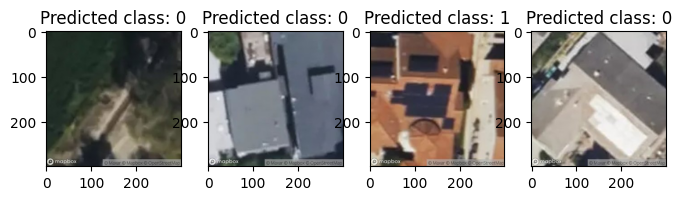

In [38]:
img_dir = "data/mapbox"
fig, ax = plt.subplots(1,4,figsize=(8,6))

for i, img_path in enumerate(Path(img_dir).iterdir()):
    img = image.load_img(img_path, target_size=(300,300))   
    # Convert the image to an array
    img_array = image.img_to_array(img) 
    # Expand dimensions to match the shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)  
    # Preprocess the image (e.g., normalize pixel values)
    img_array /= 255.0  # Change this preprocessing step based on how your model was trained   
    # Perform inference
    predictions = model.predict(img_array, verbose=0); 
    # Convert the probability to a class label
    predicted_class = (predictions > 0.5).flatten().astype(int)
    arr = plt.imread(img_path)
    ax[i].imshow(arr)
    ax[i].set_title(f"Predicted class: {predicted_class[0]}")
   